<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
SỬ DỤNG MÔ HÌNH LTSM ĐỂ DỰ ĐOÁN GIÁ CHỨNG KHOÁN FPT

<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    1. Import thư viện

In [14]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    2. Đọc dữ liệu

In [17]:
# đọc dữ liệu từ file csv
df = pd.read_csv(r"C:\Users\PC\Music\intern\FPT.csv")

print(df)

      Ticker         Date/Time   Open   High    Low  Close  Volume  \
0        FPT   12/25/2018 9:15  30.89  30.89  30.89  30.89   35410   
1        FPT   12/25/2018 9:16  30.81  30.81  30.81  30.81     190   
2        FPT   12/25/2018 9:17  30.74  30.81  30.74  30.74    1120   
3        FPT   12/25/2018 9:18  30.74  30.74  30.74  30.74    2120   
4        FPT   12/25/2018 9:19  30.74  30.74  30.74  30.74   22500   
...      ...               ...    ...    ...    ...    ...     ...   
97401    FPT  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470   
97402    FPT  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820   
97403    FPT  12/22/2020 14:26  58.20  58.20  58.20  58.20     500   
97404    FPT  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500   
97405    FPT  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170   

       Open Interest  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ... 

<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    3. Mô tả dữ liệu

In [18]:
# Chuyển đổi cột "Date/Time" sang kiểu datetime
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

# Tách cột "Date/Time" thành hai cột "Date" và "Time"
df["Date"] = df["Date/Time"].dt.date
df["Time"] = df["Date/Time"].dt.time

# Xóa cột "Date/Time" nếu bạn không cần nữa
df = df.drop(columns=["Date/Time", "Open Interest"])

# Kiểm tra kết quả
print(df.head())


  Ticker   Open   High    Low  Close  Volume        Date      Time
0    FPT  30.89  30.89  30.89  30.89   35410  2018-12-25  09:15:00
1    FPT  30.81  30.81  30.81  30.81     190  2018-12-25  09:16:00
2    FPT  30.74  30.81  30.74  30.74    1120  2018-12-25  09:17:00
3    FPT  30.74  30.74  30.74  30.74    2120  2018-12-25  09:18:00
4    FPT  30.74  30.74  30.74  30.74   22500  2018-12-25  09:19:00


In [8]:
#kích thước dữ liệu
df.shape

(97406, 9)

In [13]:
#dữ liệu 5 dòng đầu
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest,Date,Time
0,FPT,30.89,30.89,30.89,30.89,35410,0,2018-12-25,09:15:00
1,FPT,30.81,30.81,30.81,30.81,190,0,2018-12-25,09:16:00
2,FPT,30.74,30.81,30.74,30.74,1120,0,2018-12-25,09:17:00
3,FPT,30.74,30.74,30.74,30.74,2120,0,2018-12-25,09:18:00
4,FPT,30.74,30.74,30.74,30.74,22500,0,2018-12-25,09:19:00


In [19]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  97406 non-null  object 
 1   Open    97406 non-null  float64
 2   High    97406 non-null  float64
 3   Low     97406 non-null  float64
 4   Close   97406 non-null  float64
 5   Volume  97406 non-null  int64  
 6   Date    97406 non-null  object 
 7   Time    97406 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 5.9+ MB


In [77]:

# Chuyển đổi cột "Date" sang kiểu datetime
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

# Chuyển đổi cột "Time" sang kiểu thời gian
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S").dt.time

# Kiểm tra kết quả
print(df.head())
print(df.dtypes)



  Ticker   Open   High    Low  Close  Volume       Date      Time   Năm
0    FPT  30.89  30.89  30.89  30.89   35410 2018-12-25  09:15:00  2018
1    FPT  30.81  30.81  30.81  30.81     190 2018-12-25  09:16:00  2018
2    FPT  30.74  30.81  30.74  30.74    1120 2018-12-25  09:17:00  2018
3    FPT  30.74  30.74  30.74  30.74    2120 2018-12-25  09:18:00  2018
4    FPT  30.74  30.74  30.74  30.74   22500 2018-12-25  09:19:00  2018
Ticker            object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Date      datetime64[ns]
Time              object
Năm                int32
dtype: object


In [78]:
#mô tả bộ dữ liệu
df.describe()

,Open,High,Low,Close,Volume,Date,Năm
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406,97406.000000
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,2020-01-20 17:25:12.424285952,2019.529844
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,2018-12-25 00:00:00,2018.000000
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,2019-08-06 00:00:00,2019.000000
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,2020-01-31 00:00:00,2020.000000
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,2020-07-14 00:00:00,2020.000000
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,2020-12-22 00:00:00,2020.000000
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,NaN,0.507049


<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    4. Tiền xử lý dữ liệu

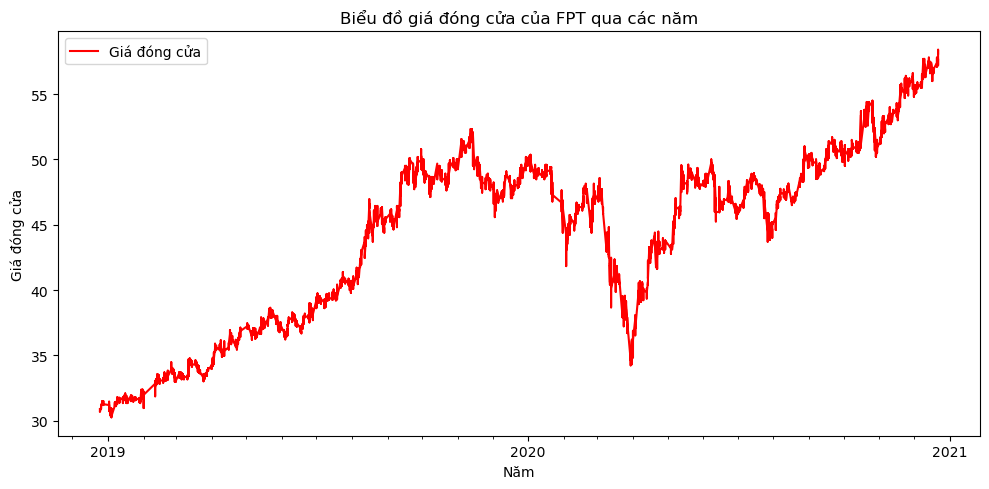

In [22]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi


# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Date')

# Lấy thông tin năm từ cột "Date"
df['Năm'] = df['Date'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


In [25]:
#tạo data frame chỉ chứa thời gian và giá đóng cửa
df1 = pd.DataFrame(df,columns=['Date','Close'])
df1.index = df1.Date
df1.drop('Date',axis=1,inplace=True)
df1

,Close
Date,
2018-12-25,30.89
2018-12-25,30.81
2018-12-25,30.74
2018-12-25,30.74
2018-12-25,30.74
...,...
2020-12-22,57.40
2020-12-22,57.40
2020-12-22,57.40


In [40]:
#chia tập dữ liệu
data = df1.values
train_data = data[:75000]
test_data = data[75000:]

In [41]:
data

array([[30.89],
       [30.81],
       [30.74],
       ...,
       [57.4 ],
       [57.4 ],
       [58.1 ]])

In [42]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [43]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [44]:
x_train

[array([0.02273535, 0.01989343, 0.01740675, 0.01740675, 0.01740675,
        0.01740675, 0.01456483, 0.02522202, 0.02522202, 0.02415631,
        0.02522202, 0.02522202, 0.02806394, 0.02806394, 0.02806394,
        0.02522202, 0.02273535, 0.02273535, 0.02664298, 0.02806394,
        0.02806394, 0.02806394, 0.02664298, 0.02806394, 0.02806394,
        0.03055062, 0.03055062, 0.03055062, 0.02806394, 0.02912966,
        0.02806394, 0.02912966, 0.02806394, 0.02912966, 0.02912966,
        0.02806394, 0.02664298, 0.02806394, 0.02806394, 0.02273535,
        0.02273535, 0.02273535, 0.02522202, 0.02415631, 0.02415631,
        0.02522202, 0.02522202, 0.02415631, 0.02522202, 0.02415631]),
 array([0.01989343, 0.01740675, 0.01740675, 0.01740675, 0.01740675,
        0.01456483, 0.02522202, 0.02522202, 0.02415631, 0.02522202,
        0.02522202, 0.02806394, 0.02806394, 0.02806394, 0.02522202,
        0.02273535, 0.02273535, 0.02664298, 0.02806394, 0.02806394,
        0.02806394, 0.02664298, 0.02806394, 0.

In [45]:
y_train

[0.024156305506216835,
 0.025222024866785153,
 0.028063943161634075,
 0.029129662522202615,
 0.025222024866785153,
 0.025222024866785153,
 0.029129662522202615,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.028063943161634075,
 0.025222024866785153,
 0.025222024866785153,
 0.029129662522202615,
 0.029129662522202615,
 0.029129662522202615,
 0.026642984014209725,
 0.030550621669626965,
 0.03197158081705154,
 0.030550621669626965,
 0.03339253996447611,
 0.028063943161634075,
 0.025222024866785153,
 0.025222024866785153,
 0.022735346358792263,
 0.022735346358792263,
 0.025222024866785153,
 0.022735346358792263,
 0.022735346358792263,
 0.025222024866785153,
 0.025222024866785153,
 0.025222024866785153,
 0.028063943161634075,
 0.028063943161634075,
 0.03445825932504443,
 0.03445825932504443,
 0.030550621669626965,
 0.03339253996447611,
 0.03339253996447611,
 0.030550621669626965,
 0.03055062166962

In [46]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    Bước 5: Xây dựng và huấn luyện mô hình học sâu LSTM

In [47]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

D:\anacconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
#huấn luyện mô hình
save_model = r"C:\Users\PC\Music\stock predict.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=10,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/10

Epoch 1: loss improved from inf to 0.03565, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 123s - 82ms/step - loss: 0.0356
Epoch 2/10

Epoch 2: loss improved from 0.03565 to 0.02168, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 141s - 94ms/step - loss: 0.0217
Epoch 3/10

Epoch 3: loss improved from 0.02168 to 0.01981, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 134s - 90ms/step - loss: 0.0198
Epoch 4/10

Epoch 4: loss improved from 0.01981 to 0.01943, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 144s - 96ms/step - loss: 0.0194
Epoch 5/10

Epoch 5: loss improved from 0.01943 to 0.01941, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 264s - 176ms/step - loss: 0.0194
Epoch 6/10

Epoch 6: loss improved from 0.01941 to 0.01921, saving model to C:\Users\PC\Music\stock predict.keras
1499/1499 - 315s - 210ms/step - loss: 0.0192
Epoch 7/10

Epoch 7: loss improved from 0.01921 to 0.0

In [54]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model(r"C:\Users\PC\Music\stock predict.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

2343/2343 ━━━━━━━━━━━━━━━━━━━━ 130s 54ms/step


<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
6. Tái sử dụng mô hình

In [65]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[75000:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

701/701 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step


<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
 Độ chính xác của mô hình

C:\Users\PC\AppData\Local\Temp\ipykernel_13720\2454555395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
C:\Users\PC\AppData\Local\Temp\ipykernel_13720\2454555395.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


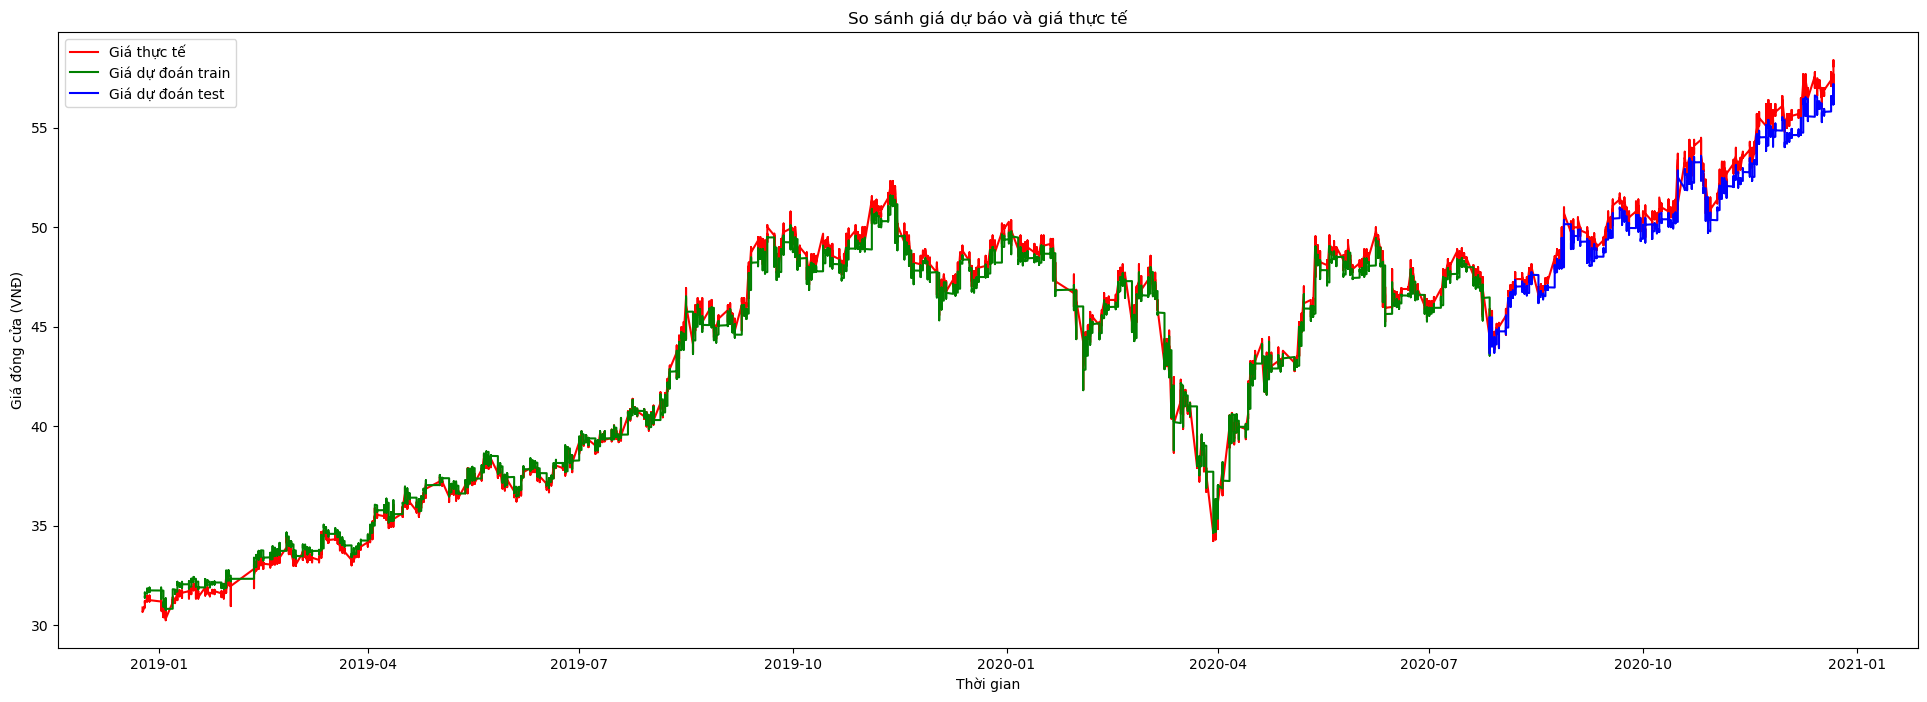

In [66]:
#lập biểu đồ so sánh
train_data1 = df1[50:75000]
test_data1 = df1[75000:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

Từ biểu đồ ta thấy giá thực tế chênh lệch khá ít so với giá dự đoán ở tập train và tập test.

In [58]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9960532098519517
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.3112369160525555
Phần trăm sai số tuyệt đối trung bình tập train: 0.00715717104300481


*  (Độ phù hợp tập Train) = 0.996

-Giá trị này rất gần 1, có nghĩa là mô hình giải thích được 99.6% biến động của dữ liệu huấn luyện.

-Điều này cho thấy mô hình đang hoạt động rất tốt trên tập Train, có khả năng dự đoán chính xác cao với dữ liệu mà nó đã học. Nhưng cũng có nguy cơ overfitting.

* MAE (Sai số tuyệt đối trung bình) = 0.311 VNĐ

-Sai số trung bình chỉ khoảng 0.31 VNĐ, tức là mô hình gần như dự đoán chính xác giá cổ phiếu trên tập Train.

* MAPE (Phần trăm sai số tuyệt đối trung bình) = 0.0071 (0.71%)
  
-Nghĩa là dự đoán của mô hình sai số trung bình 0.715% so với giá thực tế.


In [59]:
train_data1

,Close,Dự đoán
Date,,
2018-12-26,30.93,31.421009
2018-12-26,30.96,31.414684
2018-12-26,31.04,31.416700
2018-12-26,31.07,31.441402
2018-12-26,30.96,31.476929
...,...,...
2020-07-27,44.15,43.961605
2020-07-27,44.15,43.946846
2020-07-27,44.10,43.948547


In [67]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9584547625496972
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.6450917824606677
Phần trăm sai số tuyệt đối trung bình tập test: 0.012274788961123549


*  (Độ phù hợp tập Train) = 0.958

-Ý nghĩa: Mô hình có thể giải thích 95.85% biến động của dữ liệu trong tập Test.

-So với tập Train (99.6%), độ phù hợp có giảm một chút, nhưng vẫn rất cao.

* MAE (Sai số tuyệt đối trung bình) = 0.645 VNĐ

-Sai số trung bình mỗi lần dự đoán lệch khoảng 0.645 VNĐ so với giá thực tế.

-So với tập Train (0.311 VNĐ), sai số đã tăng gấp đôi.

==>Điều này cho thấy mô hình có thể đã bị overfitting nhẹ, nhưng vẫn ở mức chấp nhận được.

* MAPE (Phần trăm sai số tuyệt đối trung bình) = 1.23%
  
-Nghĩa là dự đoán trên tập Test sai số trung bình 1.23% so với giá thực tế.

-So với tập Train (0.71%), sai số tăng gần gấp đôi, nhưng vẫn ở mức thấp trong các mô hình dự đoán tài chính.

In [68]:
test_data1

,Close,Dự đoán
Date,,
2020-07-27,44.15,43.915985
2020-07-27,44.00,43.929424
2020-07-27,44.00,43.908241
2020-07-27,43.90,43.878063
2020-07-27,43.90,43.826900
...,...,...
2020-12-22,57.40,56.281666
2020-12-22,57.40,56.284531
2020-12-22,57.40,56.294930


<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


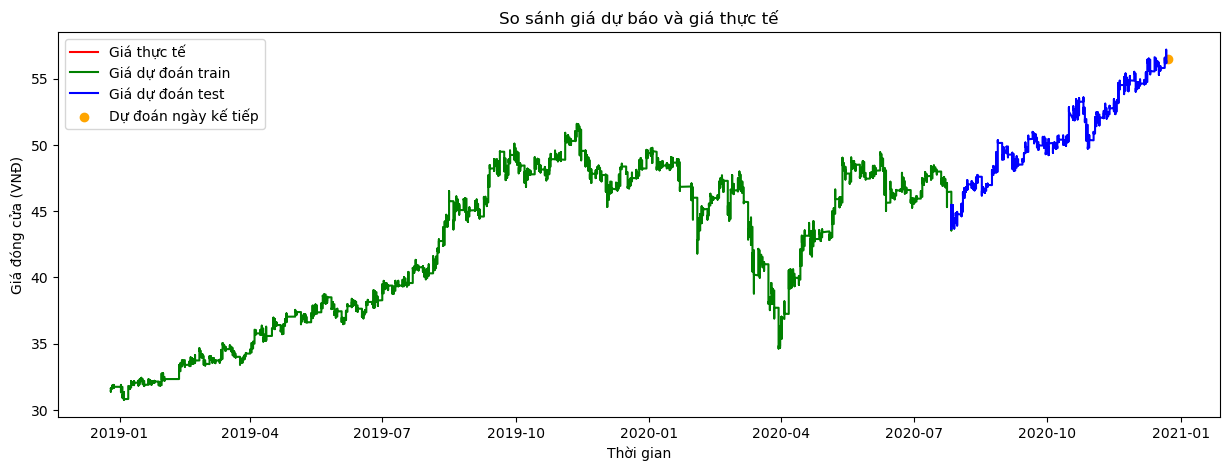

In [71]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [73]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Close': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

       Close  Giá dự đoán  Giá ngày trước
0 2020-12-23     56.50666            58.1


<a id='0'></a>
<h1 style='padding:20px; background:lightblue;color:black;border-radius:10px'>
    Thank you for watching!